<h1 style="text-align: center;">Домашнее задание №7</h1>

Для датасета из прошлого домашнего задания необходимо:  
* Сформировать двухвыборочные гипотезы касательно медиан и распределений для дискретного и непрерывного случая. Если дискретного показателя нет - создайте его дополнительно. Итого 4 гипотезы (4 пункта).
* Каждую гипотезу проверьте релевантным тестом и обоснуйте, почему выбрали именно его. 5-м пунктом будет проверка результатов с бутстрапом.
* Сравните результаты из 4 пунктов с результатами бутстрапа и обоснуйте различия, если они есть. Определите какой подход мощнее в конкретном случае и почему.

In [1]:
# Импортируем необходимые библиотеки
from itertools import combinations
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import scipy.stats as sts
from scipy.stats import ttest_ind, mannwhitneyu, norm, shapiro, normaltest, ttest_ind_from_stats

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

from warnings import simplefilter

Возьмем датасет из прошлого задания, представляющий собой данные из приложения МТС Kion по взаимодействиям пользователей с контентом за период 6 месяцев (платформа ODS - https://ods.ai/competitions/competition-recsys-21). Я выбрал следующие метрики:
* total_dur - общая продолжительность всех просмотров данного контента в секундах.
* series_cnt - количество просмотренных сериалов.
Первый признак необходимо усреднить для каждого пользователя, а второй - искусственно создать на основе данных из датасета interactions.

In [2]:
users = pd.read_csv('users.csv')
interactions = pd.read_csv('interactions.csv')
items = pd.read_csv('items.csv')

In [3]:
total_dur = interactions[['user_id', 'total_dur']]\
                        .groupby('user_id')\
                        .mean()
users = users.merge(total_dur, how='inner', on=['user_id'])
users['total_dur'] = round(users['total_dur'], 2) 

In [4]:
series = interactions[['user_id', 'item_id']]\
                .join(items[['content_type', 'item_id']]\
                .set_index('item_id'), on='item_id')

series['content_type'] = series['content_type'] == 'series'

series = series[['user_id', 'content_type']]\
                .groupby('user_id')\
                .sum()\
                .rename(columns={'content_type': 'series_cnt'})

users = users.merge(series, how='inner', on=['user_id'])

In [5]:
df = users[['user_id', 'income', 'total_dur', 'series_cnt']]

In [6]:
df.dropna(inplace=True)

Оставим пользователей с количеством фильмов до 10 включительно.

In [7]:
df = df[df['series_cnt'] >= 1]

In [8]:
df

,user_id,income,total_dur,series_cnt
0,973171,income_60_90,53159.80,2
1,962099,income_20_40,7666.71,7
4,1037719,income_60_90,8218.33,1
5,846063,income_40_60,14281.80,5
6,401219,income_40_60,2917.00,1
...,...,...,...,...
744275,848247,income_20_40,236.50,4
744276,393311,income_20_40,3151.00,1
744277,374327,income_20_40,4026.33,1
744281,1021167,income_20_40,103.00,1


### Задача 1. Сформируем двухвыборочные гипотезы касательно медиан и распределений для дискретного и непрерывного случая. 

**Дискретный случай:**

1. *Гипотеза о равенстве медиан:*
   - Дискретная переменная: количество просмотров сериалов в онлайн-кинотеатре.
   - Нулевая гипотеза(H0): "Медианы количества просмотров сериалов для двух групп равны."
   - Альтернативная гипотеза(H1): "Медианы количества просмотров сериалов для двух групп не равны."
   
Для проверки этой гипотезы можно использовать непараметрический критерий Манна-Уитни (Mann-Whitney U test). Этот тест позволяет сравнивать медианы двух независимых выборок и не требует предположений о распределении данных.

2. *Гипотеза о равенстве распределений:*
   - Дискретная переменная: количество просмотров сериалов в онлайн-кинотеатре.
   - Нулевая гипотеза(H0): "Количество просмотренных сериалов распределено одинаково для двух групп пользователей."
   - Альтернативная гипотеза(H1): "Количество просмотренных сериалов распределено не одинаково для двух групп пользователей."
   
Для проверки этой гипотезы можно использовать критерий Хи-квадрат. Критерий Хи-квадрат подходит для сравнения распределений категориальных переменных, в данном случае - количество просмотров сериалов, и позволяет оценить статистическую значимость различий между ними.

**Непрерывный случай:**

3. *Гипотеза о равенстве медиан:*
   - Непрерывная переменная: продолжительность просмотра фильмов в онлайн-кинотеатре в секундах.
   - Нулевая гипотеза(H0): "Медианы продолжительности просмотра фильмов для двух групп равны."
   - Альтернативная гипотеза(H1): "Медианы продолжительности просмотра фильмов для двух групп не равны."
   
Для проверки этой гипотезы также можно использовать непараметрический критерий Манна-Уитни (Mann-Whitney U test).

4. *Гипотеза о равенстве распределений:*
   - Непрерывная переменная: продолжительность просмотра фильмов в онлайн-кинотеатре в секундах.
   - Нулевая гипотеза(H0): "Продолжительность просмотра контента распределена одинаково для двух групп пользователей."
   - Альтернативная гипотеза(H1): "Продолжительность просмотра контента распределена не одинаково для двух групп пользователей."
   
Для проверки этой гипотезы можно использовать критерий Колмогорова-Смирнова, так как он позволяет сравнить два эмпирических распределения и оценить значимость различий между ними.

### Задача 2. Проверка гипотез релевантными тестами. 

Возьмем 2 группы пользователей с различным уровнем дохода и для них проверим гипотезы приведенные выше:
* с зарплатой от 40 до 60 тысяч рублей - income_40_60
* с зарплатой от 60 до 90 тысяч рублей - income_60_90

*Проверка 1 гипотезы с помощью критерия Манна-Уитни:*

In [9]:
_, p_val = sts.mannwhitneyu(df[df['income'] == 'income_40_60']['series_cnt'].sample(10_000), 
                                  df[df['income'] == 'income_60_90']['series_cnt'].sample(10_000))
p_val

0.24803438713541592

*Вывод: поскольку p > 0.05, следовательно медианы распределений равны.*

*Проверка 2 гипотезы с помощью критерия Хи-квадрат:*

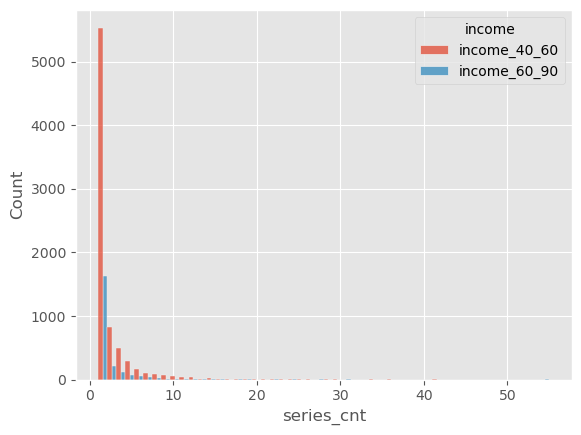

In [10]:
sns.histplot(data=df[(df['income'] == 'income_40_60') | (df['income'] == 'income_60_90')].sample(10_000),
             bins=50,
             x='series_cnt',
             hue='income',
             multiple="dodge")
plt.show()

In [12]:
chi2, p_val, _, _ = sts.chi2_contingency(df[df['income'] == 'income_40_60']['series_cnt'].sample(10_000).values, df[df['income'] == 'income_60_90']['series_cnt'].sample(10_000).values)
p_val

1.0

*Вывод: поскольку p > 0.05, следовательно количество просмотренных сериалов распределено одинаково для двух групп пользователей, в чем можно убедиться и визульно, по графику, приведенному выше.*

*Проверка 3 гипотезы с помощью критерия Манна-Уитни:*

In [13]:
_, p_val = sts.mannwhitneyu(df[df['income'] == 'income_40_60']['total_dur'], 
                                  df[df['income'] == 'income_60_90']['total_dur'])
p_val

6.804009172965869e-55

*Вывод: поскольку p < 0.05, следовательно медианы распределений не равны.*

*Проверка 4 гипотезы с помощью критерия Колмогорова-Смирнова:*

In [14]:
_, p_val = sts.ks_2samp(df[df['income'] == 'income_40_60']['total_dur'], 
                                  df[df['income'] == 'income_60_90']['total_dur'])
p_val

3.226230828500651e-51

*Вывод: поскольку p < 0.05, следовательно продолжительность просмотра контента распределена не одинаково для двух групп пользователей.*

### Задача 3. Проверка результатов с бутстрапом.

Теперь проверим для этих же категорий пользователей гипотезы с помощью бутстрапа. Для этого напишем функцию для выполнения проверки равенства медиан с помощью бутстрапа.

In [15]:
# Функция для вычисления статистики
def compute_statistic_median(data1, data2):
    # Вычисление разности медиан
    median_diff = np.median(data1) - np.median(data2)
    return median_diff

# Функция для выполнения бутстрапа
def bootstrap_median(data1, data2, statistic_func, iterations=1000):
    combined_data = np.concatenate((data1, data2))
    observed_statistic = statistic_func(data1, data2)
    bootstrap_stats = []
    for _ in range(iterations):
        # Перемешиваем данные и случайным образом делим на две группы
        permuted_data = np.random.permutation(combined_data)
        permuted_group1 = permuted_data[:len(data1)]
        permuted_group2 = permuted_data[len(data1):]
        # Вычисляем статистику на каждой итерации
        bootstrap_stat = statistic_func(permuted_group1, permuted_group2)
        bootstrap_stats.append(bootstrap_stat)
    # Вычисляем p-значение
    p_value = np.mean(np.abs(bootstrap_stats) >= np.abs(observed_statistic))
    return p_value

А также функцию для выполнения проверки равенства распределений с помощью бутстрапа.

In [16]:
# Функция для вычисления статистики
def compute_statistic_mean(data1, data2):
    # Вычисление разности средних
    mean_diff = np.mean(data1) - np.mean(data2)
    return mean_diff

# Функция для выполнения бутстрапа
def bootstrap_mean(data1, data2, statistic_func, iterations=1000):
    combined_data = np.concatenate((data1, data2))
    observed_statistic = statistic_func(data1, data2)
    bootstrap_stats = []
    for _ in range(iterations):
        # Перемешиваем данные и случайным образом делим на две группы
        permuted_data = np.random.permutation(combined_data)
        permuted_group1 = permuted_data[:len(data1)]
        permuted_group2 = permuted_data[len(data1):]
        # Вычисляем статистику на каждой итерации
        bootstrap_stat = statistic_func(permuted_group1, permuted_group2)
        bootstrap_stats.append(bootstrap_stat)
    # Вычисляем p-значение
    p_value = np.mean(np.abs(bootstrap_stats) >= np.abs(observed_statistic))
    return p_value

*Проверка 1 гипотезы с помощью бутстрапа:*

In [17]:
data_group1 = df[df['income'] == 'income_40_60']['series_cnt']
data_group2 = df[df['income'] == 'income_60_90']['series_cnt']

In [18]:
# Вызываем функцию бутстрапа и выводим результат
p_value = bootstrap_median(data_group1, data_group2, compute_statistic_median)
print(f"P-value: {p_value}")

P-value: 1.0


*Проверка 2 гипотезы с помощью бутстрапа:*

In [19]:
# Вызываем функцию бутстрапа и выводим результат
p_value = bootstrap_mean(data_group1, data_group2, compute_statistic_mean)
print(f"P-value: {p_value}")

P-value: 0.001


*Проверка 3 гипотезы с помощью бутстрапа:*

In [20]:
data_group1 = df[df['income'] == 'income_40_60']['total_dur']
data_group2 = df[df['income'] == 'income_60_90']['total_dur']

In [22]:
# Вызываем функцию бутстрапа и выводим результат
p_value = bootstrap_median(data_group1, data_group2, compute_statistic_median)
print(f"P-value: {p_value}")

P-value: 0.0


*Проверка 4 гипотезы с помощью бутстрапа:*

In [23]:
# Вызываем функцию бутстрапа и выводим результат
p_value = bootstrap_mean(data_group1, data_group2, compute_statistic_mean)
print(f"P-value: {p_value}")

P-value: 0.0


### Подведение итогов.

Сравнивая результаты из 4 пунктов с результатами бутстрапа можно выделить следующее:
* Значимые различия есть только во 2 гипотезе: проверка с помощью Хи-квадрат критерия утверждает, что распределения одинаковы, бутстрап же - наоборот, что может объясняться тем что выборки не сбалансированы, но при использовании Хи-квадрат критерия мы вынуждены фиксировать размер выборки, а при бутстрапе - нет.
* В остальном же, бутстрап подтверждает значения полученные с помощью критериев.
* Если данные имеют непрерывное распределение симметричные и сосредоточенные вокруг медиан, то бутстрап может быть более мощным, так как он не требует предположений о распределении и обеспечивает точную оценку статистической значимости. Однако, если данные не соответствуют предположениям бутстрапа, то использование других подходов, например, критерия Манна-Уитни, может быть предпочтительнее.